# 03 - Predictability & Universe Filtering

### Previously on Stock universe p. s. ...

In our previous efforts to improve generalization and downstream RL performance, we attempted to:
- Apply statistical heuristics to identify "easier" stocks
- Train predictive models to uncover latent structure

While these offered some insight, they lacked **robustness** and **transferability** across time.


### What's next:
We now shift focus toward **meta-characterizing forecastability**, moving beyond surface-level accuracy and toward deeper indicators of *learnability* and *environmental stability*.

#### Meta-Features of Forecasts
I
Instead of evaluating only R² from one-step regressors, we now extract richer *diagnostics from forecast behavior*:

- **Residual Autocorrelation**: Persistence signals underfit
- **ARCH Effects**: Volatility clustering may hint at instability
- **Skew/Kurtosis of Residuals**: Shape mismatches between model and environment
- **Entropy of Forecast Distribution**: High entropy = more chaotic returns

These become meta-features to train models that classify or rank *predictable environments*.


#### Meta-RL Labeling


To ground our theory in agent behavior, we’ll:

1. Train a small RL agent (shallow horizon, simplified environment) on each stock-month
2. Track early performance: Sharpe, alpha, drawdown, or advantage over random
3. Use this as a **proxy label** for "learnability"
4. Aggregate results over time, sectors, and macro states

This creates a **meta-learning dataset** where the labels come from actual agent-environment interactions.


### Pipeline
1. Compute rolling predictability metrics for each ticker
2. Visualize and compare scores across universe and time
3. Select top-N most “learnable” tickers for RL agent
4. Document all decisions, assumptions, and open questions




### Outcome Goal

Identify **which stocks are more “learnable”** in the near future — not just based on past returns, but through the lens of *how models perform on them*.

---

###  Why This Matters

RL agents don’t just need high alpha — they need *structure they can exploit*. This study explores:
- How to measure that structure
- How to learn from past environments
- How to build a filter that works across regimes

---


| Stage                 | Description                                                                                             |
| --------------------- | ------------------------------------------------------------------------------------------------------- |
| 🧹 Preprocessing      | Clean stock OHLCV data, compute lagged returns                                                          |
| 📈 Forecast Models    | Run simple regressors on next-month returns                                                             |
| 🔍 Diagnostics        | Extract residual meta-features, R², forecast entropy, etc.                                              |
| 🧠 Labeling           | - Regression: R² as target<br>- Ranking: (A > B)<br>- RL Reward: agent learnability                     |
| 📊 Feature Extraction | Use summary stats + diagnostic/meta features                                                            |
| 🧬 Modeling           | - Regression: Predict R²<br>- Classification: Predict "learnable"<br>- Contrastive: Rank predictability |
| 🏆 Output             | Sorted top-k stock-months or environments where RL thrives                                              |


| Section                             | Purpose                                                                                                                                                                                                          |
| ----------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| 🔧 **Setup & Pipeline Description** | High-level explanation of your RL pipeline, feature engineering, and data sources                                                                                                                                |
| 🧪 **Completed Studies**            | Summary table or list of ablation studies, e.g.:<br>`01 - Reward Function Impact`<br>`02 - Predictability Filters via R²`<br>`03 - Meta-Learnability Scores`                                                     |
| ✅ **Conclusions So Far**            | Bullet points of key findings from each experiment, e.g.:<br>– Simple R² doesn't generalize across time<br>– Residual-based features offer better stability<br>– Meta-RL proxy labels correlate with test Sharpe |
| 🔬 **Ongoing Work**                 | One-liner of what’s running or planned, so future you remembers                                                                                                                                                  |
| 📎 **Notebook Index**               | List of notebooks and what each one covers                                                                                                                                                                       |


We start with both:

First, build the regression pipeline → quick wins, visualization, baseline.

Then, shift to contrastive ranking → build a PairwiseMetaDataset, use XGBoostRanker or SiameseNet.

Ready to begin with the regression version using:

LinearReg + RF residuals

Autocorr / Ljung-Box / ARCH tests

Predict next-month R²?



In [1]:
# SETUP: Imports & Paths ===========================
import jupyter
from src.utils.system import boot, Notify

boot()
import os
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from tqdm import tqdm

from src.data.feature_pipeline import basic_chart_features,load_base_dataframe
from src.predictability.easiness import rolling_sharpe, rolling_r2, rolling_info_ratio, rolling_autocorr
from src.predictability.pipeline import generate_universe_easiness_report
from IPython import display

from src.experiments.experiment_tracker import ExperimentTracker
from src.config import TOP2_STOCK_BY_SECTOR


from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from scipy.stats import skew, kurtosis, entropy
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf, acovf


import warnings
warnings.filterwarnings("ignore")


C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:

EXPERIENCE_NAME = "stock_universe_predictability_selection__MetaFeatures__MetaRlLabeling"
FEATURES_PATH = f"../data/cache/features_{EXPERIENCE_NAME}.pkl"
TARGETS_PATH = f"../data/cache/targets_{EXPERIENCE_NAME}.pkl"
META_PATH = f"../data/cache/meta_{EXPERIENCE_NAME}.pkl"

excluded_tickers=['CEG', 'GEHC', 'GEV', 'KVUE', 'SOLV']
excluded_tickers.sort()
#tickers = TOP2_STOCK_BY_SECTOR

config={
    "regressor":"RandomForestRegressor",
    "n_estimators": 100,
    "random_state":314
}
run_settings={
    "excluded_tickers": excluded_tickers,
    "min_samples": 10,
    "cv_folds": 3,
    "lags": 5,
    "start_date":"2022-01-01",
    "end_date":"2023-01-01"
}

# Config section


In [3]:
# LOAD OHLCV ==========================================


ohlcv_df = load_base_dataframe()
ohlcv_df['date'] = pd.to_datetime(ohlcv_df['date'])
ohlcv_df = ohlcv_df[(ohlcv_df['date'] >= run_settings["start_date"]) & (ohlcv_df['date'] < run_settings["end_date"])]
ohlcv_df['month'] = ohlcv_df['date'].dt.to_period('M')
ohlcv_df['return_1d'] = ohlcv_df['return_1d'].fillna(0)
ohlcv_df['sector_id'] = ohlcv_df['sector_id'].fillna('unknown')
ohlcv_df['industry_id'] = ohlcv_df['industry_id'].fillna('unknown')

In [4]:
# Meta-feature & Label Extraction =======================
"""
# BASIC PREPROCESSING ===================================
excluded_tickers = run_settings["excluded_tickers"]
min_samples = run_settings["min_samples"]
cv_folds = run_settings["cv_folds"]
lags = run_settings["lags"]
start_date = run_settings["start_date"]
end_date = run_settings["end_date"]

# CROP THE SAMPLE =======================================
tickers = ohlcv_df['symbol'].unique()[:100]
tickers = tickers[~np.isin(tickers, excluded_tickers)]
tickers = ["AAPL","MSFT","JPM","V",'LLY','UNH','AMZN','TSLA','META','GOOGL','GE','UBER','COST','WMT','XOM','CVX'.'NEE','SO','AMT','PLD','LIN','SHW']

# FOR POC ONLY


ohlcv_df = ohlcv_df.copy()
ohlcv_df['date'] = pd.to_datetime(ohlcv_df['date'])
ohlcv_df = ohlcv_df[(ohlcv_df['date'] >= start_date) & (ohlcv_df['date'] < end_date)]
ohlcv_df['month'] = ohlcv_df['date'].dt.to_period('M')
ohlcv_df['return_1d'] = ohlcv_df['return_1d'].fillna(0)
"""
tickers = ohlcv_df['symbol'].unique()
tickers = tickers[~np.isin(tickers, excluded_tickers)]
def mean_policy(arr):
    # return np.median(arr)
    return pd.Series(arr).ewm(span=5).mean().iloc[-1]

# Attempt to load if already exists (resumability)
if all([os.path.exists(path) for path in [FEATURES_PATH, TARGETS_PATH, META_PATH]]):
    features = joblib.load(FEATURES_PATH)
    targets = joblib.load(TARGETS_PATH)
    metadata = joblib.load(META_PATH)
    print("Loaded cached feature/target/meta lists.")
    
else:
    features, targets, metadata = [], [], []
    #tickers = ohlcv_df['symbol'].unique()
    #tickers = [t for t in tickers if t not in run_settings["excluded_tickers"]]
    for symbol in tqdm(tickers):
        df = ohlcv_df[ohlcv_df['symbol'] == symbol].sort_values('date').copy()
        months = df['month'].unique()
        for i in range(1, len(months)):
            m_t = months[i-1]
            m_t1 = months[i]
            df_t = df[df['month'] == m_t]
            df_t1 = df[df['month'] == m_t1]
            if len(df_t1) < run_settings["min_samples"]:
                continue
            r1d = df_t['return_1d'].astype(float).values
            v = df_t['volume'].astype(float).values
            feat = {
                'symbol': symbol,
                'month_str': str(m_t),
                'mean_return': mean_policy(r1d),
                'std_return': r1d.std(),
                'skew': skew(r1d),
                'kurtosis': kurtosis(r1d),
                'entropy': entropy(np.histogram(r1d, bins=10, density=True)[0] + 1e-8),
                'vol_mean': mean_policy(v),
                'vol_std': v.std()
            }
            # Residual diagnostics from simple RF on t+1
            df_lag = df_t1.copy()
            for lag in range(1, run_settings['lags'] + 1):
                df_lag[f'return_lag_{lag}'] = df_lag['return_1d'].shift(lag)
            df_lag = df_lag.dropna()
            if len(df_lag) < run_settings["min_samples"]:
                continue
            X = df_lag[[f'return_lag_{i}' for i in range(1, run_settings['lags'] + 1)]].values
            y = df_lag['return_1d'].values
            model = RandomForestRegressor(n_estimators=config['n_estimators'], random_state=config['random_state'])
            model.fit(X, y)
            residuals = y - model.predict(X)
            # Meta-diagnostics
            ljung_pval = acorr_ljungbox(residuals, lags=[run_settings['lags']], return_df=True).iloc[0]['lb_pvalue']
            feat['ljung_pval'] = ljung_pval
            feat['resid_acf1'] = pd.Series(residuals).autocorr(lag=1)
            feat['resid_std'] = residuals.std()
            feat['resid_skew'] = skew(residuals)
            feat['resid_kurtosis'] = kurtosis(residuals)
            # Predictability label (cross-val R²)
            cv_r2 = mean_policy(cross_val_score(model, X, y, cv=run_settings["cv_folds"], scoring='r2'))
            features.append(feat)
            targets.append(cv_r2)
            metadata.append((symbol, str(m_t)))
    # Save for future resumes
    joblib.dump(features, FEATURES_PATH)
    joblib.dump(targets, TARGETS_PATH)
    joblib.dump(metadata, META_PATH)
    print("Feature/target/meta lists saved.")


100%|██████████| 498/498 [50:39<00:00,  6.10s/it]


Feature/target/meta lists saved.


In [5]:
# DataFrame Construction  ============================
X_df = pd.DataFrame(features)
y_df = pd.Series(targets, name='cv_r2')
meta_df = pd.DataFrame(metadata, columns=['symbol', 'month'])

In [6]:
# Scaling & Preparation ==============================

X = X_df.drop(columns=['symbol', 'month_str'])
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
X_df

,symbol,month_str,mean_return,std_return,skew,kurtosis,entropy,vol_mean,vol_std,ljung_pval,resid_acf1,resid_std,resid_skew,resid_kurtosis
0,MMM,2022-01,-0.005358,0.014943,-0.917692,0.261870,1.955084,5.306873e+06,1.376213e+06,0.886434,-0.210568,0.011435,1.832094,3.398314
1,MMM,2022-02,0.001679,0.017579,0.814226,2.843657,1.590270,5.706021e+06,1.373277e+06,0.505866,0.119984,0.006063,-1.128147,0.402776
2,MMM,2022-03,-0.003659,0.014061,-0.485777,-1.162192,2.074097,3.501205e+06,2.003990e+06,0.700678,-0.169013,0.005657,-0.729054,-0.444286
3,MMM,2022-04,-0.005525,0.012495,0.065468,0.467243,1.963829,4.301652e+06,9.406939e+05,0.711076,0.163132,0.006389,-0.567922,-0.850302
4,MMM,2022-05,0.004323,0.017465,-0.008367,-0.379037,1.857123,3.591724e+06,8.993571e+05,0.786330,0.001595,0.007651,0.674921,1.893767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5470,SPY,2022-07,0.010781,0.011772,0.329663,-0.951383,2.055845,7.726631e+07,1.048544e+07,0.952517,-0.152453,0.005413,-0.929827,1.288795
5471,SPY,2022-08,-0.008836,0.011893,-0.388961,0.848996,1.825026,7.652040e+07,1.403157e+07,0.452747,-0.158132,0.007806,-0.515058,0.510301
5472,SPY,2022-09,-0.009335,0.014769,-0.392043,0.294917,1.929729,1.252384e+08,2.141793e+07,0.528805,-0.458920,0.008030,0.086436,-1.084477
5473,SPY,2022-10,0.003589,0.017147,0.080973,-1.173194,1.867774,9.657081e+07,1.877312e+07,0.469245,-0.337390,0.008210,1.430019,2.145926


In [9]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
import joblib
from src.env.base_trading_env import CumulativeTradingEnv

RL_LABELS_PATH = f"../../data/cache/meta_rl_labels_{EXPERIENCE_NAME}.pkl"

feature_cols = ["return_1d", "volume"]  # Or your preferred features
episode_length = 18  # Or whatever fits your month
train_steps = 300    # Fast!
min_ep_len = 18
# Resume logic: Load meta_df with RL columns if available
if os.path.exists(RL_LABELS_PATH):
    meta_df_rl = pd.read_pickle(RL_LABELS_PATH)
    print("Loaded meta_df with RL columns.")
else:
    # Copy original meta_df and initialize RL columns
    meta_df_rl = meta_df.copy()
    meta_df_rl['agent_reward'] = np.nan
    meta_df_rl['random_reward'] = np.nan
    meta_df_rl['advantage'] = np.nan
    meta_df_rl['sharpe'] = np.nan
    meta_df_rl['cum_return'] = np.nan
    meta_df_rl['alpha'] = np.nan


for i, row in tqdm(meta_df_rl.iterrows(), total=len(meta_df_rl), desc="Meta-RL Agent Loop"):
    # Skip if already computed
    if not np.isnan(meta_df_rl.loc[i, 'agent_reward']):
        continue

    symbol, month = row['symbol'], row['month']
    df_env = ohlcv_df[(ohlcv_df['symbol'] == symbol) & (ohlcv_df['month'] == month)].sort_values("date")
    if len(df_env) < min_ep_len:
        min_ep_len = len(df_env)
        print('new min',min_ep_len)
    if len(df_env) < episode_length:
        print('x',len(df_env) ,episode_length)
        continue  # Not enough data, skip

    try:
        env = CumulativeTradingEnv(
            df=df_env,
            feature_cols=feature_cols,
            episode_length=episode_length,
            transaction_cost=0.0001,
            seed=42
        )
        env = gym.wrappers.FlattenObservation(env)
        check_env(env, warn=True)

        model = PPO("MlpPolicy", env, verbose=0, n_steps=64, batch_size=16, learning_rate=0.001, seed=42)
        model.learn(total_timesteps=train_steps)

        # Evaluate PPO
        obs, _ = env.reset()
        agent_rewards, done = [], False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, truncated, info = env.step(action)
            agent_rewards.append(reward)
        agent_reward = np.sum(agent_rewards)

        # Evaluate Random
        obs, _ = env.reset()
        random_rewards, done = [], False
        while not done:
            action = env.action_space.sample()
            obs, reward, done, truncated, info = env.step(action)
            random_rewards.append(reward)
        random_reward = np.sum(random_rewards)

        advantage = agent_reward - random_reward

        meta_df_rl.loc[i, 'agent_reward'] = agent_reward
        meta_df_rl.loc[i, 'random_reward'] = random_reward
        meta_df_rl.loc[i, 'advantage'] = advantage
        meta_df_rl.loc[i, 'sharpe'] = info.get("episode_sharpe", np.nan)
        meta_df_rl.loc[i, 'cum_return'] = info.get("cumulative_return", np.nan)
        meta_df_rl.loc[i, 'alpha'] = info.get("alpha", np.nan)
        #print(info)
        
    except Exception as e:
        print(f"Skipped ({symbol})",e)


Meta-RL Agent Loop:  96%|█████████▌| 5247/5475 [3:18:06<06:55,  1.82s/it]  

Skipped (WBD) Stock WBD does not have enough data (18) for episode of length 18


Meta-RL Agent Loop: 100%|██████████| 5475/5475 [3:24:43<00:00,  2.24s/it]


In [10]:
meta_df_rl.to_csv('mrl.csv')
meta_df_rl['target'] = (meta_df_rl['advantage'] > 0).astype(int)
meta_df_rl

,symbol,month,agent_reward,random_reward,advantage,sharpe,cum_return,alpha,target
0,MMM,2022-01,0.097855,-0.033373,0.131228,-0.057553,-0.034267,0.041187,1
1,MMM,2022-02,0.000000,0.147681,-0.147681,0.345755,0.156193,0.191800,0
2,MMM,2022-03,0.037366,-0.084139,0.121506,-0.741778,-0.081414,-0.151347,1
3,MMM,2022-04,0.000000,-0.002991,0.002991,0.005193,-0.004000,0.082890,1
4,MMM,2022-05,0.028873,-0.036429,0.065302,-0.272195,-0.036945,-0.003939,1
...,...,...,...,...,...,...,...,...,...
5470,SPY,2022-07,0.000000,-0.060716,0.060716,-0.098066,-0.059780,-0.133956,1
5471,SPY,2022-08,0.026824,0.018599,0.008225,-0.152020,0.017850,0.047072,1
5472,SPY,2022-09,0.000000,-0.021695,0.021695,0.160151,-0.023127,0.045375,1
5473,SPY,2022-10,-0.033524,-0.048062,0.014539,-0.387718,-0.048676,-0.079808,1


In [ ]:
feature_cols = [col for col in meta_df_rl.columns if col not in ['symbol', 'month', 'agent_reward', 'random_reward', 'advantage', 'target']]
feature_cols

In [11]:
meta_df_rl['target'].value_counts()

target
1    3373
0    2102
Name: count, dtype: int64

In [13]:
# Make sure columns are compatible for merge
X_df['month'] = X_df['month_str']
merged = pd.merge(X_df, meta_df_rl, on=['symbol', 'month'], how='inner')
merged

,symbol,month_str,mean_return,std_return,skew,kurtosis,entropy,vol_mean,vol_std,ljung_pval,...,resid_skew,resid_kurtosis,month,agent_reward,random_reward,advantage,sharpe,cum_return,alpha,target
0,MMM,2022-01,-0.005358,0.014943,-0.917692,0.261870,1.955084,5.306873e+06,1.376213e+06,0.886434,...,1.832094,3.398314,2022-01,0.097855,-0.033373,0.131228,-0.057553,-0.034267,0.041187,1
1,MMM,2022-02,0.001679,0.017579,0.814226,2.843657,1.590270,5.706021e+06,1.373277e+06,0.505866,...,-1.128147,0.402776,2022-02,0.000000,0.147681,-0.147681,0.345755,0.156193,0.191800,0
2,MMM,2022-03,-0.003659,0.014061,-0.485777,-1.162192,2.074097,3.501205e+06,2.003990e+06,0.700678,...,-0.729054,-0.444286,2022-03,0.037366,-0.084139,0.121506,-0.741778,-0.081414,-0.151347,1
3,MMM,2022-04,-0.005525,0.012495,0.065468,0.467243,1.963829,4.301652e+06,9.406939e+05,0.711076,...,-0.567922,-0.850302,2022-04,0.000000,-0.002991,0.002991,0.005193,-0.004000,0.082890,1
4,MMM,2022-05,0.004323,0.017465,-0.008367,-0.379037,1.857123,3.591724e+06,8.993571e+05,0.786330,...,0.674921,1.893767,2022-05,0.028873,-0.036429,0.065302,-0.272195,-0.036945,-0.003939,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5470,SPY,2022-07,0.010781,0.011772,0.329663,-0.951383,2.055845,7.726631e+07,1.048544e+07,0.952517,...,-0.929827,1.288795,2022-07,0.000000,-0.060716,0.060716,-0.098066,-0.059780,-0.133956,1
5471,SPY,2022-08,-0.008836,0.011893,-0.388961,0.848996,1.825026,7.652040e+07,1.403157e+07,0.452747,...,-0.515058,0.510301,2022-08,0.026824,0.018599,0.008225,-0.152020,0.017850,0.047072,1
5472,SPY,2022-09,-0.009335,0.014769,-0.392043,0.294917,1.929729,1.252384e+08,2.141793e+07,0.528805,...,0.086436,-1.084477,2022-09,0.000000,-0.021695,0.021695,0.160151,-0.023127,0.045375,1
5473,SPY,2022-10,0.003589,0.017147,0.080973,-1.173194,1.867774,9.657081e+07,1.877312e+07,0.469245,...,1.430019,2.145926,2022-10,-0.033524,-0.048062,0.014539,-0.387718,-0.048676,-0.079808,1


In [14]:
feature_cols = [
    col for col in merged.columns
    if col not in ['symbol', 'month', 'month_str', 'agent_reward', 'random_reward', 'advantage', 'target']
]

X = merged[feature_cols]
y = merged['target']

# Scale features
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
feature_cols

['mean_return',
 'std_return',
 'skew',
 'kurtosis',
 'entropy',
 'vol_mean',
 'vol_std',
 'ljung_pval',
 'resid_acf1',
 'resid_std',
 'resid_skew',
 'resid_kurtosis',
 'sharpe',
 'cum_return',
 'alpha']

In [15]:
#ohlcv_df.sort_values(by="date").head().to_csv('ohlcv_to_upload.csv')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89       420
           1       0.97      0.89      0.93       675

    accuracy                           0.91      1095
   macro avg       0.91      0.92      0.91      1095
weighted avg       0.92      0.91      0.91      1095

Confusion Matrix:
[[400  20]
 [ 74 601]]


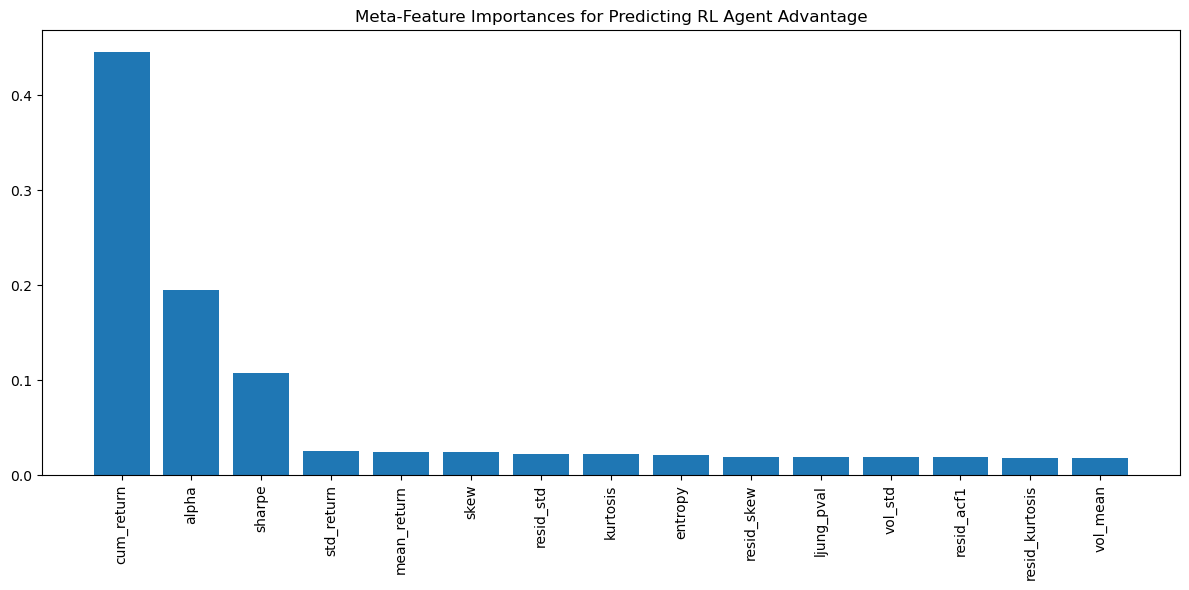

In [16]:
import matplotlib.pyplot as plt
import numpy as np

importances = clf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.bar(range(len(importances)), importances[sorted_idx])
plt.xticks(range(len(importances)), [feature_cols[i] for i in sorted_idx], rotation=90)
plt.title("Meta-Feature Importances for Predicting RL Agent Advantage")
plt.tight_layout()
plt.show()


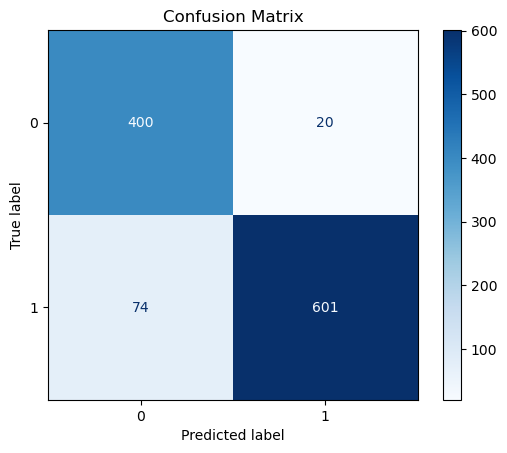

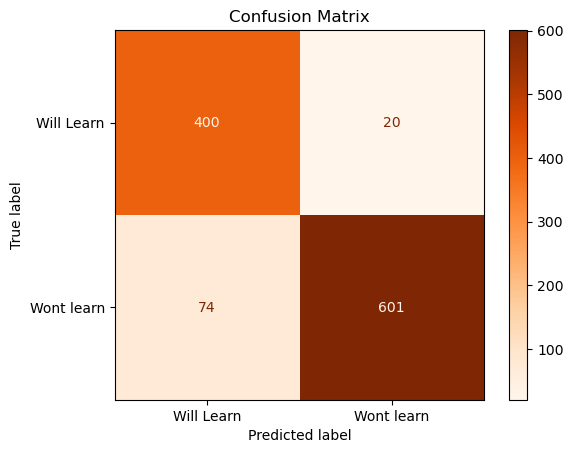

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# y_true: true labels, y_pred: predicted labels
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)  # Optional: color map
plt.title("Confusion Matrix")
plt.show()


class_names = ['Will Learn', 'Wont learn']  # Adjust to your problem

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
xxxxxxxxxx

## Quick Recap
We want to estimate how "predictable" each stock is in a given month, using meta-features of its behavior.

#### Pipeline: 
**Loop: For each (stock, month)**
From Previous Month (t) we will extract features. From the returns in month t, we compute:
* Mean
* Std 
* Skew 
* Kurtosis
* Entropy of returns
* Mean of volumne
* Std of volume

These become the meta-features for that stock-month.

**From Following Month (t+1) we will compute "predictability"**

* With 5 lags of daily returns from month t+1 will try to predict daily returns using a RandomForestRegressor
* Evaluate performance with cross-validated R² (cv_r2)
* Analyze residuals from this model with the Ljung–Box test for autocorrelation ⇒ gives ljung_pval

These become the target labels or diagnostic scores

| Feature                 | Description                                        |
| ----------------------- | -------------------------------------------------- |
| `resid_acf1`            | Autocorrelation of residuals (lag 1)               |
| `resid_std`             | Std of residuals                                   |
| `resid_skew`            | Skewness of residuals                              |
| `resid_kurtosis`        | Kurtosis of residuals                              |
| `resid_ljung_pval`      | p-value of Ljung-Box test for residual autocorr    |
| `return_autocorr_1d`    | Lag-1 autocorrelation of raw 1D returns            |
| `volatility_clustering` | Rolling std autocorrelation (vol clustering proxy) |


In [ ]:
# FEATURE + LABEL EXTRACTION ============================
features, targets, metadata = [], [], []
def mean_policy(arr):
    #return np.median(arr)
    return pd.Series(arr).ewm(span=5).mean().iloc[-1]
    
for symbol in tqdm(tickers):

    df = ohlcv_df[ohlcv_df['symbol'] == symbol].sort_values('date').copy()
    df['month'] = df['date'].dt.to_period('M')
    months = df['month'].unique()
  
    for i in range(1, len(months)):
        m_t = months[i-1]
        m_t1 = months[i]

        df_t = df[df['month'] == m_t]
        df_t1 = df[df['month'] == m_t1]
        
        if len(df_t1) < min_samples:
            continue
        
        # Feature engineering from month t ---
        r1d = df_t['return_1d'].astype(float).values
        v = df_t['volume'].astype(float).values

        feat = {
            'symbol': symbol,
            'month_str': str(m_t),
            'mean_return': mean_policy(r1d),#r1d.mean(),
            'std_return': r1d.std(),
            'skew': skew(r1d),
            'kurtosis': kurtosis(r1d),
            'entropy': entropy(np.histogram(r1d, bins=10, density=True)[0] + 1e-8),
            'vol_mean': mean_policy(v),#v.mean(),
            'vol_std': v.std()
        }

        # Residual diagnostics from simple RF on t+1
        df_lag = df_t1.copy()
        
        for lag in range(1,  run_settings['lags'] + 1):
            df_lag[f'return_lag_{lag}'] = df_lag['return_1d'].shift(lag)
            
       
        df_lag = df_lag.dropna()
        if len(df_lag) < min_samples:
            continue
        
        
        
        X = df_lag[[f'return_lag_{i}' for i in range(1, run_settings['lags'] + 1)]].values
        y = df_lag['return_1d'].values

        model = RandomForestRegressor(n_estimators=config['n_estimators'], random_state=config['random_state'])
        model.fit(X, y)
        
        residuals = y - model.predict(X)
                
        # Meta-diagnostics ---
        ljung_pval = acorr_ljungbox(residuals, lags=[run_settings['lags']], return_df=True).iloc[0]['lb_pvalue']
        feat['ljung_pval'] = ljung_pval

        # Predictability label (cross-val R²) ---
        cv_r2 = mean_policy(cross_val_score(model, X, y, cv=cv_folds, scoring='r2'))#.mean()
        #print({"cv_r2":cv_r2,"ljung_pval":ljung_pval})
        features.append(feat)
        targets.append(cv_r2)
        metadata.append((symbol, str(m_t)))


In [ ]:
# BUILD DTASETS ============================================
X_df = pd.DataFrame(features)
y_df = pd.Series(targets, name='cv_r2')
meta_df = pd.DataFrame(metadata, columns=['symbol', 'month'])


X = X_df.drop(columns=['symbol', 'month_str', 'month_dt'])

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# TIME-BASED TRAIN/TEST SPLIT ===============================


X_df['month_dt'] = pd.to_datetime(X_df['month_str'])

split_date = unique_months[int(0.8 * len(unique_months))]

train_mask = X_df['month_dt'] < split_date
test_mask = X_df['month_dt'] >= split_date

X_train, X_test = X_scaled[train_mask], X_scaled[test_mask]
y_train, y_test = y_df[train_mask], y_df[test_mask]
meta_test = meta_df[test_mask.values].copy()

In [ ]:
# REGRESSOR TRAINING ========================================
import xgboost as xgb
#final_model = RandomForestRegressor(n_estimators=config['n_estimators'], random_state=config['random_state'])
final_model = RandomForestRegressor(n_estimators=500, random_state=config['random_state'])

final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)


In [ ]:
# REGRESSION RESULTS ========================================
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_policy((y_test - y_pred)**2))

print(f"Test RMSE: {rmse:.4f}, R²: {r2:.4f}")

meta_test['true_r2'] = y_test.values
meta_test['predicted_r2'] = y_pred

top = meta_test.sort_values('predicted_r2', ascending=False).head(10)
print("Top predictable stock-months:")
print(top)

# Plot
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("True R²")
plt.ylabel("Predicted R²")
plt.title("Meta-Predictability Regression")
plt.grid(True)
plt.tight_layout()
plt.show()

# ONLY ON FINAL MODEL
# 100 - Test RMSE: 1.2389, R²: -0.1142
# 300 - Test RMSE: 1.2394, R²: -0.1150 
# 500 - Test RMSE: 1.2317, R²: -0.1013

# WITH MEDIAN AND ROBUST
# 500 - Test RMSE: 0.4345, R²: -0.1013

# WITH EWM
# 500 - Test RMSE: 1.5385, R²: -0.0056

In [ ]:
xxxxxxxxxx

In [ ]:
# Predictability Meta-Feature Pipeline with Structural Diagnostics

import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis, entropy
from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import RobustScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# === CONFIG ===
min_samples = 10
cv_folds = 3
lag_window = 5

# === DATA ===
df = ohlcv_df[(ohlcv_df['date'] >= "2022-01-01") & (ohlcv_df['date'] < "2023-01-01")].copy()
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.to_period('M')
df['return_1d'] = df['return_1d'].fillna(0)
df.drop(columns=["sector_id", "industry_id"], inplace=True)

# === TICKERS ===
#tickers = ["AAPL", "MSFT", "JPM", "V", 'LLY', 'UNH', 'AMZN', 'TSLA', 'META', 'GOOGL',
           'GE', 'UBER', 'COST', 'WMT', 'XOM', 'CVX', 'NEE', 'SO', 'AMT', 'PLD', 'LIN', 'SHW']



features, targets, metadata = [], [], []

def mean_policy(arr):
    #return np.median(arr)
    return pd.Series(arr).ewm(span=5).mean().iloc[-1]

# === FEATURE + LABEL EXTRACTION ===
for symbol in tqdm(tickers):
    symbol_df = df[df['symbol'] == symbol].sort_values('date').copy()
    months = symbol_df['month'].unique()

    for i in range(1, len(months)):
        m_t = months[i - 1]
        m_t1 = months[i]

        df_t = symbol_df[symbol_df['month'] == m_t].copy()
        df_t1 = symbol_df[symbol_df['month'] == m_t1].copy()

        if len(df_t1) < min_samples:
            continue

        r1d = df_t['return_1d'].astype(float).values
        v = df_t['volume'].astype(float).values

        hist = np.histogram(r1d, bins=10, density=True)[0] + 1e-8
        acf_vals = acf(r1d, nlags=5, fft=True)[1:6]  # exclude lag 0
        acf_names = {f'acf_lag_{i+1}': val for i, val in enumerate(acf_vals)}

        time_idx = np.arange(len(r1d)).reshape(-1, 1)
        try:
            trend_r2 = RandomForestRegressor().fit(time_idx, r1d).score(time_idx, r1d)
        except:
            trend_r2 = 0

        feat = {
            'symbol': symbol,
            'month_str': str(m_t),
            'mean_return': mean_policy(r1d),
            'std_return': np.std(r1d),
            'skew': skew(r1d),
            'kurtosis': kurtosis(r1d),
            'entropy': entropy(hist),
            'vol_median': mean_policy(v),
            'vol_std': np.std(v),
            'trend_r2': trend_r2,
            **acf_names
        }

        # Residual diagnostics on t+1
        df_lag = df_t1.copy()
        for lag in range(1, lag_window + 1):
            df_lag[f'return_lag_{lag}'] = df_lag['return_1d'].shift(lag)
        df_lag = df_lag.dropna()

        if len(df_lag) < min_samples:
            continue

        X = df_lag[[f'return_lag_{i}' for i in range(1, lag_window + 1)]].values
        y = df_lag['return_1d'].values

        model = RandomForestRegressor(n_estimators=100, random_state=314)
        model.fit(X, y)
        residuals = y - model.predict(X)

        ljung_pval = acorr_ljungbox(residuals, lags=[lag_window], return_df=True).iloc[0]['lb_pvalue']
        feat['ljung_pval'] = ljung_pval

        cv_r2 = np.mean(cross_val_score(model, X, y, cv=cv_folds, scoring='r2'))
        features.append(feat)
        targets.append(cv_r2)
        metadata.append((symbol, str(m_t)))


In [ ]:

# === DATAFRAME PREP ===
X_df = pd.DataFrame(features)
y_df = pd.Series(targets, name="cv_r2")
X_df['month_dt'] = pd.to_datetime(X_df['month_str'])
meta_df = pd.DataFrame(metadata, columns=["symbol", "month"])
X = X_df.drop(columns=['symbol', 'month_str', 'month_dt'])

# === SCALING ===
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# === SPLIT ===
split_idx = int(0.8 * len(X_scaled))
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y_df[:split_idx], y_df[split_idx:]
meta_test = meta_df.iloc[split_idx:].copy()

# === REGRESSOR TRAINING ===
final_model = RandomForestRegressor(n_estimators=500, random_state=314)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

# === METRICS ===
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.4f}, R²: {r2:.4f}")

meta_test['true_r2'] = y_test.values
meta_test['predicted_r2'] = y_pred
print("Top predictable stock-months:")
print(meta_test.sort_values('predicted_r2', ascending=False).head(10))

# === VISUALIZATION ===
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("True R²")
plt.ylabel("Predicted R²")
plt.title("Meta-Predictability Regression")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# === Contrastive Dataset Builder ===
import random
from sklearn.utils import shuffle


def build_contrastive_dataset(X, y, meta, n_pairs=20000, margin=0.02):
    X_pairs = []
    y_pairs = []
    meta_pairs = []

    num_samples = len(y)
    attempts = 0
    max_attempts = n_pairs * 10

    while len(X_pairs) < n_pairs and attempts < max_attempts:
        i, j = np.random.choice(num_samples, size=2, replace=False)
        r2_i, r2_j = y[i], y[j]

        diff = r2_i - r2_j
        if abs(diff) < margin:
            attempts += 1
            continue

        if diff > 0:
            X_diff = X[i] - X[j]
            y_label = 1
        else:
            X_diff = X[j] - X[i]
            y_label = 0

        X_pairs.append(X_diff)
        y_pairs.append(y_label)
        meta_pairs.append((meta.iloc[i].to_dict(), meta.iloc[j].to_dict()))
        attempts += 1

    return np.array(X_pairs), np.array(y_pairs), meta_pairs

# === Contrastive Model ===
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


def train_contrastive_model(X_pairs, y_pairs):
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_pairs, y_pairs)
    return clf


# === Scoring Function from Single Sample ===
class ScoringWrapper:
    def __init__(self, model):
        self.model = model

    def score(self, x):
        # Compare x to 0-vector (neutral baseline)
        x = x.reshape(1, -1)
        return self.model.decision_function(x)[0]


# === Example Usage ===
# X_scaled, y_df, meta_df assumed to exist

X_pairs, y_pairs, meta_pairs = build_contrastive_dataset(X_scaled, y_df.values, meta_df, n_pairs=20000, margin=0.02)
print("Class distribution:", np.bincount(y_pairs))

contrastive_model = train_contrastive_model(X_pairs, y_pairs)
scorer = ScoringWrapper(contrastive_model)
scores = [scorer.score(x) for x in X_scaled]
meta_df['score'] = scores

# Score individual months:
scores = [scorer.score(x) for x in X_scaled]
meta_df['score'] = scores
meta_df['true_r2'] = y_df.values
# Top predictable stock-months by contrastive model:
top_ranked = meta_df.sort_values('score', ascending=False).head(10)
print(top_ranked)


In [ ]:
top = meta_df.sort_values("score", ascending=False).head(10)
bottom = meta_df.sort_values("score", ascending=True).head(10)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
sns.histplot(meta_df['score'], bins=40, kde=True)
plt.title("Contrastive Predictability Scores")
plt.xlabel("Score")
plt.ylabel("Count")
plt.grid(True)
plt.show()

In [ ]:
sns.scatterplot(data=meta_df, x='true_r2', y='score')
plt.xlabel("True R²")
plt.ylabel("Contrastive Score")
plt.title("Score vs Ground Truth R²")
plt.grid(True)
plt.show()

In [ ]:
xxxxxxxxxxxxxxxxxxxxx

In [ ]:
# Agent-Based Meta-Labeling (Advantage Estimation)
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import gymnasium as gym
import warnings
warnings.filterwarnings("ignore")
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

class WrappedStockTradingEnv(StockTradingEnv):
    def step(self, actions):
        # Call the original step method
        state, reward, done, info = super().step(actions)

        # Wrap the reward in a NumPy array so DummyVecEnv works properly
        if not isinstance(reward, (list, np.ndarray)):
            reward = np.array([reward])
        
        return state, reward, done, info
# === ADVANTAGE FUNCTION ===
def compute_agent_advantage(df, symbol, month_str):
    df_symbol = df[df['symbol'] == symbol].copy()
    df_symbol['month'] = df_symbol['date'].dt.to_period("M")
    df_month = df_symbol[df_symbol['month'] == pd.Period(month_str)]
    df_next = df_symbol[df_symbol['month'] == pd.Period(month_str) + 1]

    if len(df_next) < min_samples:
        return np.nan

    try:
        # Define environment
        env_df = df_next[['date', 'open', 'high', 'low', 'close', 'volume', 'return_1d','symbol']].copy()
        env_df.rename(columns={'symbol':"tic"},inplace=True)
        env_df = env_df.reset_index(drop=True)
        stock_dim = 1
        env_kwargs = {
            "hmax": 100,
            "initial_amount": 100000,
            "buy_cost_pct": 0.001,
            "sell_cost_pct": 0.001,
            "state_space": 6 * stock_dim + 1,
            "stock_dim": stock_dim,
            "tech_indicator_list": ["return_1d"],
            "action_space": stock_dim,
            "reward_scaling": 1e-4,
          "num_stock_shares":1
        }
        #env = DummyVecEnv([lambda: StockTradingEnv(df=env_df, **env_kwargs)])
        env = DummyVecEnv([lambda: WrappedStockTradingEnv(df=env_df, **env_kwargs)])
        # Train PPO Agent
        model = PPO("MlpPolicy", env, verbose=0)
        model.learn(total_timesteps=5000)

        # Evaluate
        obs = env.reset()
        total_reward_agent = 0
        total_reward_random = 0

        for _ in range(len(env_df)):
            action, _states = model.predict(obs)
            obs, rewards, dones, info = env.step(action)
            total_reward_agent += float(rewards)

        # Evaluate random policy
        obs = env.reset()
        for _ in range(len(env_df)):
            action = env.action_space.sample()
            obs, rewards, dones, info = env.step(action)
            total_reward_random += float(rewards)

        advantage = total_reward_agent - total_reward_random
        return advantage

    except Exception as e:
        print(f"Advantage error for {symbol}-{month_str}: {e}")
        return np.nan

# === COMPUTE ADVANTAGE FOR META-DF ===
meta_df['advantage'] = meta_df.apply(lambda row: compute_agent_advantage(df, row['symbol'], row['month']), axis=1)

# === ADVANTAGE RESULTS ===
print("Top agent-advantaged stock-months:")
print(meta_df.sort_values('advantage', ascending=False).head(10))

# === Save Results (Optional) ===
# meta_df.to_csv("predictability_meta_results.csv", index=False)


In [ ]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
import joblib

RL_LABELS_PATH = f"cache/meta_rl_labels_{EXPERIENCE_NAME}.pkl"

feature_cols = ["return_1d", "volume"]  # Or your preferred features
episode_length = 30  # Or whatever fits your month
train_steps = 300    # Fast!

# Resume logic: Load meta_df with RL columns if available
if os.path.exists(RL_LABELS_PATH):
    meta_df_rl = pd.read_pickle(RL_LABELS_PATH)
    print("Loaded meta_df with RL columns.")
else:
    # Copy original meta_df and initialize RL columns
    meta_df_rl = meta_df.copy()
    meta_df_rl['agent_reward'] = np.nan
    meta_df_rl['random_reward'] = np.nan
    meta_df_rl['advantage'] = np.nan

for i, row in tqdm(meta_df_rl.iterrows(), total=len(meta_df_rl), desc="Meta-RL Agent Loop"):
    # Skip if already computed
    if not np.isnan(meta_df_rl.loc[i, 'agent_reward']):
        continue

    symbol, month = row['symbol'], row['month']
    df_env = ohlcv_df[(ohlcv_df['symbol'] == symbol) & (ohlcv_df['month'] == month)].sort_values("date")

    if len(df_env) < episode_length:
        continue  # Not enough data, skip

    try:
        env = CumulativeTradingEnv(
            df=df_env,
            feature_cols=feature_cols,
            episode_length=episode_length,
            transaction_cost=0.0001,
            seed=42
        )
        env = gym.wrappers.FlattenObservation(env)
        check_env(env, warn=True)

        model = PPO("MlpPolicy", env, verbose=0, n_steps=64, batch_size=16, learning_rate=0.001, seed=42)
        model.learn(total_timesteps=train_steps)

        # Evaluate PPO
        obs, _ = env.reset()
        agent_rewards, done = [], False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, truncated, info = env.step(action)
            agent_rewards.append(reward)
        agent_reward = np.sum(agent_rewards)

        # Evaluate Random
        obs, _ = env.reset()
        random_rewards, done = [], False
        while not done:
            action = env.action_space.sample()
            obs, reward, done, truncated, info = env.step(action)
            random_rewards.append(reward)
        random_reward = np.sum(random_rewards)

        advantage = agent_reward - random_reward

        meta_df_rl.loc[i, 'agent_reward'] = agent_reward
        meta_df_rl.loc[i, 'random_reward'] = random_reward
        meta_df_rl.loc[i, 'advantage'] = advantage

    except Exception as e:
        print(f"Skipped ({symbol}, {month}): {e}")
        continue

    # Save progress every 10
    if i % 10 == 0:
        meta_df_rl.to_pickle(RL_LABELS_PATH)
        print(f"Checkpointed at row {i}")

# Final save
meta_df_rl.to_pickle(RL_LABELS_PATH)
print("Saved meta_df with RL columns.")


In [ ]:
# === Agent-Based Meta-Labeling: Advantage Estimation ===
import pandas as pd
import numpy as np
import gym
import warnings
import time
from tqdm import tqdm
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

warnings.filterwarnings("ignore")

# === PPO Utility Functions ===

class WrappedStockTradingEnv(StockTradingEnv):
    def step(self, actions):
        # Call the original step method
        state, reward, _,done, info = super().step(actions)

        # Wrap the reward in a NumPy array so DummyVecEnv works properly
        if not isinstance(reward, (list, np.ndarray)):
            reward = np.array([reward])
        
        return state, reward, done, info
    
class PatchedStockTradingEnv(StockTradingEnv):
    def step(self, actions):
        #print('pst', actions)
        obs, reward, done,truncated, info = super().step(actions)
        #print('pst2')
        reward = np.array([reward], dtype=np.float32)
        done = np.array([done])
        info = [info]
        
        # SB3 expects 5 items: obs, reward, terminated, truncated, info
        info = {"dummy": True}
        return obs, reward, done, done, info
    
def train_ppo_agent(env, timesteps=5000):

    model = PPO("MlpPolicy", env, verbose=0)
  
    model.learn(total_timesteps=timesteps)

    return model
def evaluate_policy(env, model, steps):
    obs = env.reset()
    total_reward = 0

    for _ in range(steps):
       
        action, _ = model.predict(obs)
     
        truncated = False
        obs, rewards, terminated, info = env.step(action)

        done = terminated or truncated
     
        total_reward += float(np.squeeze(rewards))
        if done:
            break
    #print('xxx 5',total_reward)
    return total_reward

def evaluate_random(env, steps):
    #print('x')
    obs = env.reset()
    #print('x1',steps)
    total_reward = 0
    for _ in range(steps):
        #print('x2',env.action_space.sample())
        action = env.action_space.sample()
        #print('x3',action)
        truncated = False
        #print('x4',env.step(np.array([action]).astype(np.float32)))
        obs, rewards, terminated, info = env.step(np.array([action]).astype(np.float32))
        #print('x5',rewards)
        done = terminated or truncated
        #print(f"Type of rewards: {type(rewards)}, value: {rewards}")
        total_reward += float(np.squeeze(rewards))
        if done:
            break
    return total_reward


# === ADVANTAGE FUNCTION ===

def compute_agent_advantage(df, symbol, month_str, min_samples=10):
    try:
        #print(month_str)
        df_symbol = df[df['symbol'] == symbol].copy()
        df_symbol['month'] = df_symbol['date'].dt.to_period("M")
        df_next = df_symbol[df_symbol['month'] == pd.Period(month_str) + 1].copy()
        #print(1)
        if len(df_next) < min_samples:
            return np.nan

        # Prepare DataFrame for env
        df_next.rename(columns={"symbol": "tic"}, inplace=True)
        env_df = df_next[['date', 'open', 'high', 'low', 'close', 'volume', 'return_1d', 'tic']].reset_index(drop=True)
        #print(2)
        env_kwargs = {
            "hmax": 100,
            "initial_amount": 100000,
            "buy_cost_pct": np.array([0.001]),   # <-- FIXED
            "sell_cost_pct": np.array([0.001]),  # <-- FIXED
            "state_space": 4,
            "stock_dim": 1,
            "tech_indicator_list": ["return_1d"],
            "action_space": 1,
            "reward_scaling": 1e-4,
            "num_stock_shares": 1
        }

        #env = DummyVecEnv([lambda: StockTradingEnv(df=env_df, **env_kwargs)])
        env = DummyVecEnv([lambda: PatchedStockTradingEnv(df=env_df, **env_kwargs)])
        #print(3)
        #print(env.reset())
        #print(env.action_space.sample())
        #np.array([env.action_space.sample()]
        #print(env.step([action]))
        print('x')
        # Train PPO and compute reward
        model = train_ppo_agent(env)
        #print(4)
        steps = len(env_df)
        print(4)
        reward_agent = evaluate_policy(env, model, steps)
        print("reward_agent",reward_agent)
        reward_random = evaluate_random(env, steps)
        print("reward_random",reward_agent)
        advantage = reward_agent - reward_random
        print("advantage",advantage)
        #print('y')
        return advantage

    except Exception as e:
        print(f"[Advantage error] {symbol}-{month_str}: {e}")
        return np.nan

# === APPLY TO META_DF ===

print("Computing RL agent advantages... (this may take a while)")
start = time.time()
meta_df['advantage'] = meta_df.apply(
    lambda row: compute_agent_advantage(df, row['symbol'], row['month']),
    axis=1
)
end = time.time()

print(f"Finished in {end - start:.1f} seconds.")
print("\nTop stock-months by RL agent advantage:")
print(meta_df.sort_values('advantage', ascending=False).head(10))

# Optional: Save
# meta_df.to_csv("predictability_meta_with_advantage.csv", index=False)

In [ ]:
meta_df.to_csv("predictability_meta_with_advantage.csv", index=False)

In [ ]:
meta_df['advantage']

In [ ]:
meta_df['target'] = (meta_df['advantage'] > 0).astype(int)

In [ ]:
meta_df

In [ ]:
fdf = pd.DataFrame(features)
fdf

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# === Construct target variable ===
meta_df = meta_df.copy()
meta_df['target'] = (meta_df['advantage'] > 0).astype(int)

# === Select features (drop metadata) ===
feature_cols = [col for col in meta_df.columns if col not in ['symbol', 'month', 'advantage', 'target']]
X = meta_df[feature_cols]
y = meta_df['target']

# === Optional: scale features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=314)

# === Train classifier ===
clf = RandomForestClassifier(n_estimators=200, random_state=314)
clf.fit(X_train, y_train)

# === Evaluate ===
y_pred = clf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


import matplotlib.pyplot as plt

importances = clf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[sorted_idx])
plt.xticks(range(len(importances)), [feature_cols[i] for i in sorted_idx], rotation=90)
plt.title("Feature Importances")
plt.tight_layout()
plt.show()


In [ ]:
# Merge on symbol and month (use consistent naming)
fdf['month'] = fdf['month_str']  # Align column name for merge
merged = pd.merge(fdf.drop(columns='month_str'), meta_df, on=['symbol', 'month'], how='inner')

# Define target and features
y = merged['target']
X = merged.drop(columns=['symbol', 'month', 'advantage', 'target'])  # Keep 'score' and 'true_r2'

# Scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=314)

# Train classifier
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=200, random_state=314)
clf.fit(X_train, y_train)

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix
y_pred = clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

importances = clf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]
feature_names = X.columns if hasattr(X, 'columns') else merged.drop(columns=['symbol', 'month', 'advantage', 'target']).columns

plt.figure(figsize=(12, 6))
plt.bar(range(len(importances)), importances[sorted_idx])
plt.xticks(range(len(importances)), [feature_names[i] for i in sorted_idx], rotation=90)
plt.title("Feature Importances for Predicting Agent Advantage")
plt.tight_layout()
plt.show()


In [ ]:
#from imblearn.over_sampling import SMOTE

#sm = SMOTE(random_state=42)
#X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
#clf.fit(X_resampled, y_resampled)

# Train classifier
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=200, random_state=314,class_weight='balanced')
clf.fit(X_train, y_train)

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix
y_pred = clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

In [ ]:
import numpy as np

# Ensure both are NumPy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

class_0_idx = np.where(y_train == 0)[0]
class_1_idx = np.where(y_train == 1)[0]

n_to_add = len(class_1_idx) - len(class_0_idx)
oversampled_idx = np.random.choice(class_0_idx, size=n_to_add, replace=True)

X_oversampled = np.concatenate([X_train, X_train[oversampled_idx]], axis=0)
y_oversampled = np.concatenate([y_train, y_train[oversampled_idx]], axis=0)

shuffle_idx = np.random.permutation(len(y_oversampled))
X_balanced = X_oversampled[shuffle_idx]
y_balanced = y_oversampled[shuffle_idx]




In [ ]:
# Train your classifier
clf = RandomForestClassifier( n_estimators=200, random_state=314,class_weight='balanced')
clf.fit(X_balanced, y_balanced)

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix
y_pred = clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix

# 1. Create the classifier
xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",   # binary classification
    eval_metric="logloss",         # evaluation metric
    use_label_encoder=False,       # suppress warning
    random_state=314
)

# 2. Fit on the oversampled data
xgb_clf.fit(X_balanced, y_balanced)

# 3. Predict on the test set
y_pred = xgb_clf.predict(X_test)

# 4. Evaluate
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.005,0.01, 0.05, 0.1],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0]
}

# Create the classifier
xgb_clf = xgb.XGBClassifier(random_state=314, use_label_encoder=False, eval_metric='logloss')

# GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    cv=5,
    scoring='f1_weighted',  # or 'roc_auc', 'accuracy', etc.
    verbose=1,
    n_jobs=-1
)

# Fit
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Params:", grid_search.best_params_)

# Predict on test set
y_pred = grid_search.predict(X_test)

# Evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


In [ ]:
from sklearn.calibration import CalibratedClassifierCV
calibrated_xgb = CalibratedClassifierCV(grid_search.best_estimator_, method='isotonic', cv=3)
calibrated_xgb.fit(X_train, y_train)

y_pred = calibrated_xgb.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

In [ ]:
2. Feature engineering:
Add features that measure uncertainty, volatility clustering, or market randomness like:

Hurst exponent

GARCH volatility

Rolling ADF p-values

Change-point detection count